#Projet Deep learning
Dans cette partie on apporte des amélioration sur notre modeleBaseLine




# 0-Installation des libraire et mise en palce de google drive 

In [ ]:
!pip install pyyaml h5py #pour sauvegarder le modèle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importation des différentes librairies utiles pour le notebook
#Pour ignorer les warning.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy
import random
from numpy import mean
from numpy import std

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py

#Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,img_to_array, load_img #from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model
from sklearn.model_selection import KFold
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import os  #pour accéder aux fonctionnalité systèmes
import sys 
from os import listdir
from os.path import isfile, join
import cv2  # Library to solve computer vision problems
import glob  # = global is used to return all file paths that match a specific pattern

In [ ]:
# pour monter son Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet


'/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'

# 1-Récupération des jeux de données

In [ ]:
#pour télécharger le zip file 
!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

--2022-12-02 09:12:50--  https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605545 (7.3M) [application/zip]
Saving to: ‘Tiger-Fox-Elephant.zip.10’

Tiger-Fox-Elephant. 100%[===================>]   7.25M  19.1MB/s    in 0.4s    

2022-12-02 09:12:50 (19.1 MB/s) - ‘Tiger-Fox-Elephant.zip.10’ saved [7605545/7605545]



In [ ]:
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")

#3-Initialisation de fonctions globales qui serviront tout le long de notre étude.

In [ ]:
# constantes globales
IMG_SIZE=124
COLUMNS = 16 # Nombre d'images à afficher

In [ ]:
def plot_curves(histories):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,top = 0.9, wspace = 0.25, hspace = 0)
  for i in range(len(histories)):
    # plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='red', label='test')  
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='red',label='test')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
  plt.show()

In [ ]:
 """
 Téléchargement de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return training_data
 """
 def create_training_data(path_data, list_classes):  
  training_data=[]   #Tableau de retour 
  for classes in list_classes: # tiger et tiger_negative
      path = os.path.join(path_data, classes)
      class_num = list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
          training_data.append([new_array, class_num])  # on remplit notre tableau 
        except Exception as e:
          pass  
  return training_data   

 """
 Creation de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return X,y
 """ 
 def create_X_y (path_data, list_classes):
      # récupération des données
      training_data = create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)  #-1 The new shape should be compatible with the original shape.  
      y=np.array(y)
      return X,y 

 """
 Nettoyage de données : conversion en foat et normalisation 
 @Param xtrain 
 @Param xtest
 @Return xtrain_norm, xtest_norm
 """ 
 def clean_data(x): 
    # convertion d'entier en float
    xtrain_norm = x.astype('float32')
    # normalisation entre 0 et 1
    xtrain_norm = xtrain_norm / 255.0
    return xtrain_norm 

 """
 Affichage de données : 
 @Param X 
 @Param y
 """ 
 def plot_examples(X,y):
  plt.figure(figsize=(15,15))
  for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 lit, met les images en BGR et matplotlib lit du RGB
    X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    plt.imshow(X[i],cmap=plt.cm.binary)  
    plt.xlabel('classe ' + str(y[i]))

In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['tiger','Tiger_negative_class']
batchSize = 32
epochs = 20

X, y = create_X_y(my_path, my_classes) # load dataset
X = clean_data(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 

y_train.shape = (y_train.shape[0],1)
y_test.shape = (y_test.shape[0],1)

datagen = ImageDataGenerator(width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               rotation_range=5,
                               fill_mode='nearest')
train_iterator = datagen.flow(X_train, y_train, batch_size= batchSize, shuffle=False, save_prefix='augmente_train')#,subset='training')#save_to_dir='./idgTrain', save_prefix='augmente_train', 

data batch shape: (32, 124, 124, 3)
labels batch shape: (32, 1)


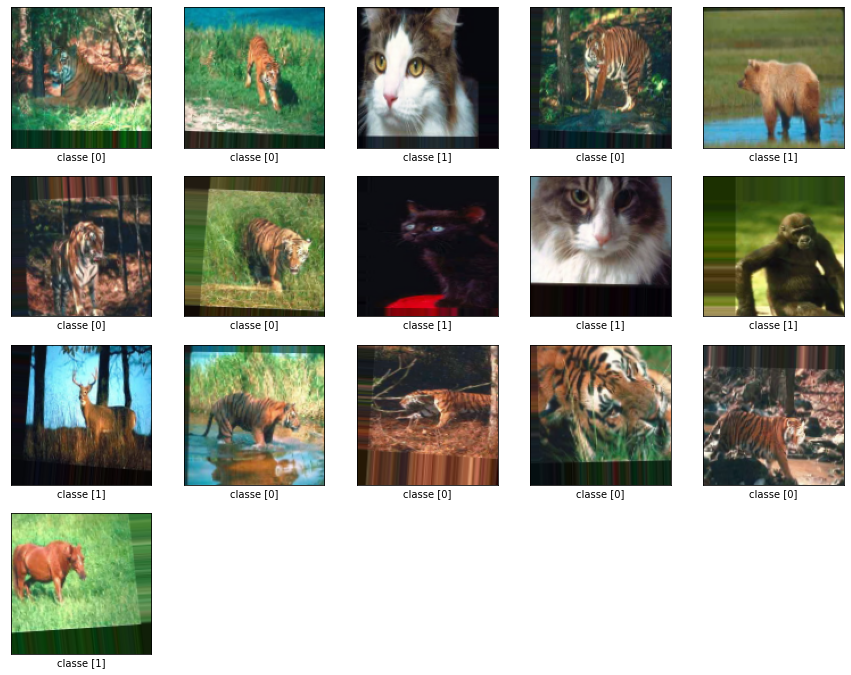

In [ ]:
for X_batch, y_batch in train_iterator: #permet de charger des lots de données
    print('data batch shape:',X_batch.shape)
    print('labels batch shape:',y_batch.shape)
    plot_examples(X_batch,y_batch)
    break

##Image Data Generator

Essai 3

In [ ]:
"""
Pour le modèle baseline nous avons fait un modèle assez simple :
une couche conv2D et un pooling suivi bien entendu par un datten et une couche dense avant d'avoir une couche 2nale avec un softmax
"""
def define_model_baseLine():
  model = models.Sequential()   # Pour initializer le modèle
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_1"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_1")) # pour réduire l'échantillonnage

  model.add(layers.Flatten(input_shape = (124,124),name="Flatten_1"))  # Applatir la matrice de maxPooling 
 
  model.add(layers.Dense(1,activation = 'sigmoid',name="Dense_final"))  # Couche de sortie 

  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) # To finalise the model and make it completely ready to use.
  return model

In [ ]:
modelBaseLine= define_model_baseLine()
print (modelBaseLine.summary())
history = modelBaseLine.fit(train_iterator, epochs=epochs, validation_data =(X_test, y_test),verbose = 1) 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 Maxpooling2D_1 (MaxPooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                                 
 Flatten_1 (Flatten)         (None, 123008)            0         
                                                                 
 Dense_final (Dense)         (None, 1)                 123009    
                                                                 
Total params: 123,905
Trainable params: 123,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
5/5 [==============================] - 3s 425ms/step - loss: 1.8040 - accuracy: 0.5000 - val_loss:

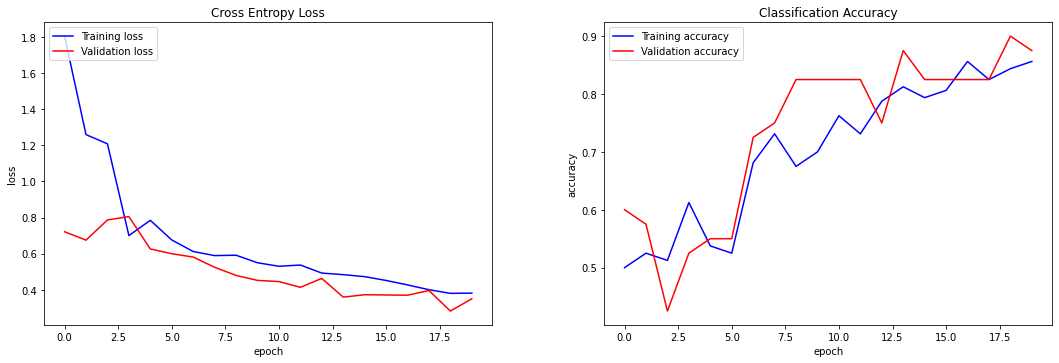

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = modelBaseLine.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = modelBaseLine.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

2/2 - 0s - loss: 0.3506 - accuracy: 0.8750 - 125ms/epoch - 62ms/step
2/2 [==============================] - 0s 34ms/step
la moyenne =  0.3280217


In [ ]:
def define_model_ameliorer():
  model = models.Sequential()   # Pour initializer le modèle
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_1"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_1")) # pour réduire l'échantillonnage
  
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_2"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_2")) # pour réduire l'échantillonnage

  model.add(Dropout(0.5))  
  model.add(layers.Flatten(input_shape = (124,124), name="Flatten_1"))  # Applatir la matrice de maxPooling 
  
  model.add(layers.Dense(128,activation='relu',name="Dense_2")) # Couche de 50 neuronne avec comme fonction d'activation relu 
  
  model.add(layers.Dense(1,activation = 'sigmoid',name="Dense_final"))  # Couche de sortie 
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) # To finalise the model and make it completely ready to use.
  return model

In [ ]:
modelIDGAmeliorer = define_model_ameliorer()
print (modelIDGAmeliorer.summary())
history = modelIDGAmeliorer.fit(train_iterator, epochs=epochs, validation_data =(X_test, y_test),verbose = 1) 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 Maxpooling2D_1 (MaxPooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                                 
 Conv2D_2 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 Maxpooling2D_2 (MaxPooling2  (None, 31, 31, 32)       0         
 D)                                                              
                                                                 
 dropout_7 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 Flatten_1 (Flatten)         (None, 30752)            

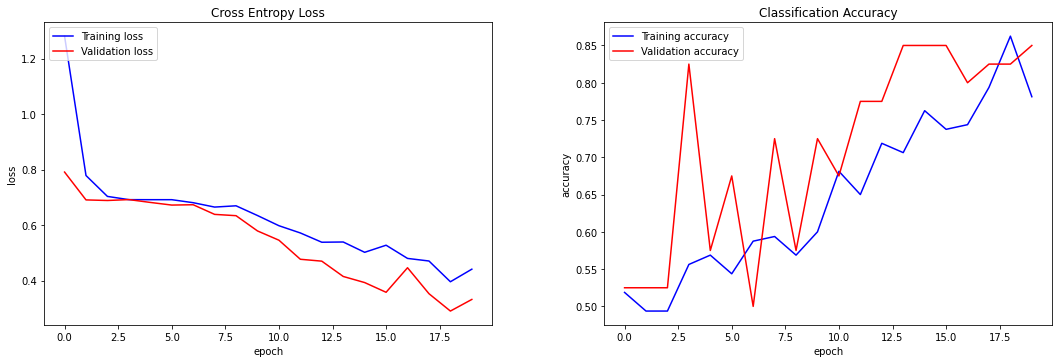

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = modelBaseLine.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = model.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

2/2 - 0s - loss: 0.3317 - accuracy: 0.8500 - 193ms/epoch - 96ms/step
2/2 [==============================] - 0s 40ms/step
la moyenne =  0.37903237


##Test

In [ ]:
"""
Pour le modèle baseline nous avons fait un modèle assez simple :
une couche conv2D et un pooling suivi bien entendu par un datten et une couche dense avant d'avoir une couche 2nale avec un softmax
"""
def define_model_3_couches_conv():
  model = models.Sequential()   # Pour initializer le modèle
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_1"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_1")) # pour réduire l'échantillonnage

  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_2"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_2")) 

  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_3"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_3"))  

  model.add(Dropout(0.5)) # 0.1 c'est la probabilité de désactivation 
  model.add(layers.Flatten(input_shape = (124,124),name="Flatten_1"))  # Applatir la matrice de maxPooling 
  model.add(layers.Dense(128,activation='relu',name="Dense_2")) # Couche de 50 neuronne avec comme fonction d'activation relu 
  model.add(layers.Dense(1,activation = 'sigmoid',name="Dense_final"))  # Couche de sortie 
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) # To finalise the model and make it completely ready to use.
  return model

In [ ]:
model3Couches= define_model_3_couches_conv()
print (model3Couches.summary())
history = model3Couches.fit(train_iterator, epochs=epochs, validation_data =(X_test, y_test),verbose = 1) 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 Maxpooling2D_1 (MaxPooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                                 
 Conv2D_2 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 Maxpooling2D_2 (MaxPooling2  (None, 31, 31, 32)       0         
 D)                                                              
                                                                 
 Conv2D_3 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 Maxpooling2D_3 (MaxPooling2  (None, 15, 15, 32)      

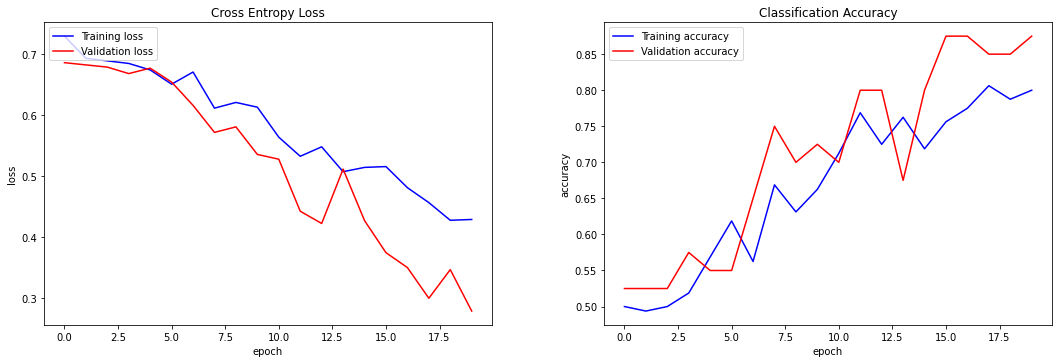

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = modelBaseLine.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = modelBaseLine.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

2/2 - 0s - loss: 0.2782 - accuracy: 0.8750 - 197ms/epoch - 99ms/step


2/2 [==============================] - 0s 47ms/step
la moyenne =  0.52931607


###Améliorer ++

In [ ]:
"""
Pour le modèle baseline nous avons fait un modèle assez simple :
une couche conv2D et un pooling suivi bien entendu par un datten et une couche dense avant d'avoir une couche 2nale avec un softmax
"""
def define_model_4_couches_conv():
  model = models.Sequential()   # Pour initializer le modèle
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_1"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_1")) # pour réduire l'échantillonnage

  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_2"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_2")) 

  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_3"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_3"))  

  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_4"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_4"))  

  model.add(Dropout(0.5)) # 0.1 c'est la probabilité de désactivation 
  model.add(layers.Flatten(input_shape = (124,124),name="Flatten_1"))  # Applatir la matrice de maxPooling 
  model.add(layers.Dense(128,activation='relu',name="Dense_2")) # Couche de 50 neuronne avec comme fonction d'activation relu 
  model.add(layers.Dense(1,activation = 'sigmoid',name="Dense_final"))  # Couche de sortie 
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) # To finalise the model and make it completely ready to use.
  return model

In [ ]:
model4Couches = define_model_4_couches_conv()
print (model4Couches.summary())
history = model4Couches.fit(train_iterator, epochs=epochs, validation_data =(X_test, y_test),verbose = 1) 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 Maxpooling2D_1 (MaxPooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                                 
 Conv2D_2 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 Maxpooling2D_2 (MaxPooling2  (None, 31, 31, 32)       0         
 D)                                                              
                                                                 
 Conv2D_3 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 Maxpooling2D_3 (MaxPooling2  (None, 15, 15, 32)     

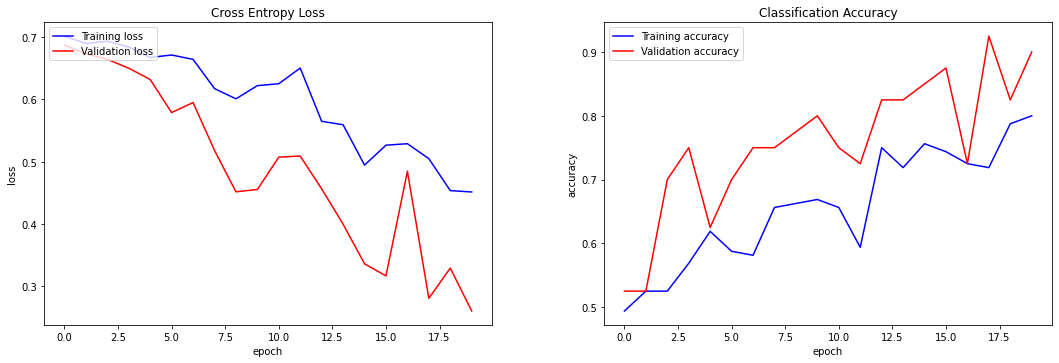

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = modelBaseLine.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = model.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

2/2 - 0s - loss: 0.2605 - accuracy: 0.9000 - 204ms/epoch - 102ms/step


2/2 [==============================] - 0s 46ms/step
la moyenne =  0.37918934


##Améliorer +++

In [ ]:
"""
Pour le modèle baseline nous avons fait un modèle assez simple :
une couche conv2D et un pooling suivi bien entendu par un datten et une couche dense avant d'avoir une couche 2nale avec un softmax
"""
def define_model_bis():
  model = models.Sequential()   # Pour initializer le modèle
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_1"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_1")) # pour réduire l'échantillonnage

  model.add(Conv2D(filters=64, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_2"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_2")) 

  model.add(Conv2D(filters=128, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_3"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_3"))  

  model.add(Dropout(0.5)) # 0.1 c'est la probabilité de désactivation 
  model.add(layers.Flatten(input_shape = (124,124),name="Flatten_1"))  # Applatir la matrice de maxPooling 
  model.add(layers.Dense(100,activation='relu',name="Dense_2")) # Couche de 50 neuronne avec comme fonction d'activation relu 
  model.add(layers.Dense(1,activation = 'sigmoid',name="Dense_final"))  # Couche de sortie 
  model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) # To finalise the model and make it completely ready to use.
  return model

In [ ]:
modelBis = define_model_bis()
print (modelBis.summary())
history = modelBis.fit(train_iterator, epochs=epochs, validation_data =(X_test, y_test),verbose = 1) 

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 Maxpooling2D_1 (MaxPooling2  (None, 62, 62, 32)       0         
 D)                                                              
                                                                 
 Conv2D_2 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 Maxpooling2D_2 (MaxPooling2  (None, 31, 31, 64)       0         
 D)                                                              
                                                                 
 Conv2D_3 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 Maxpooling2D_3 (MaxPooling2  (None, 15, 15, 128)    

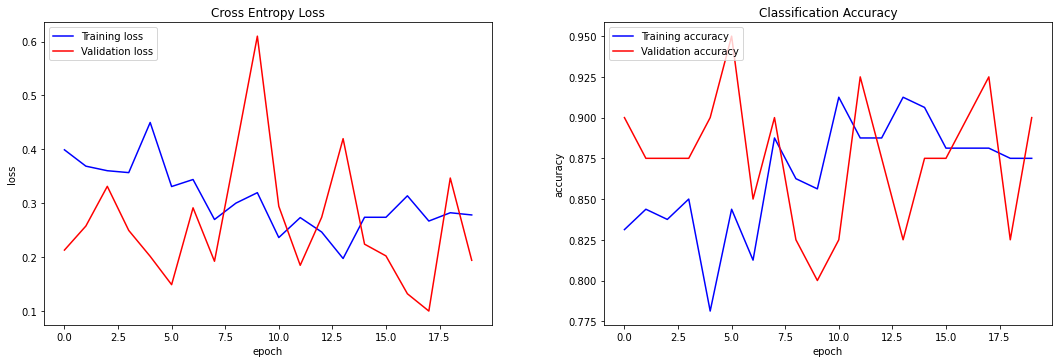

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = modelBaseLine.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = model.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

2/2 - 1s - loss: 0.6922 - accuracy: 0.5250 - 1s/epoch - 528ms/step
2/2 [==============================] - 1s 96ms/step
la moyenne =  0.48523894
